### Numerically solving the dynamic differential equations of a protein production system. 

#### The equations are from the paper [Global signatures of protein and mRNA expression levels ](https://www.ncbi.nlm.nih.gov/labs/pmc/articles/PMC4089977/).

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.integrate import odeint


sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)

#### The first order differential equation describing the system is:
$$\frac{dP}{dt} = k_{ProteinProduction} - k_{ProteinDegradation}\times P$$
$$ k_{ProteinProduction} = k_{Translation}\times R $$

In [10]:
def dy_dx(protein, time, k_translation, k_degradation, mRNA):
    return k_translation*mRNA - k_degradation*protein

#### From the paper, $k_{ProteinDegradation}$ and $R$ are constants. 

In [ ]:
rnd = np.random.default_rng(12345)

N = 5
k_degradation = 1
k_translation = np.linspace(0.01, 0.1, N) + rnd.uniform()
mRNA = 5 # (R in the paper)


## Inital conditions
times = np.linspace(0, 10, 1000)
proteins0 = 0.0  # protein at time=0


protein_produced = []

plt.figure(figsize=(6, 6))


for a in range(N):
    proteins = odeint(dy_dx, proteins0, times, args=(k_translation[a], k_degradation, mRNA))
    proteins = np.array(proteins).flatten()
    protein_produced.append(proteins)
    
    ax = sns.lineplot(x=times, y=protein_produced[a], label='k_trans = {}'.\
                      format(np.round(k_translation[a], 2)),\
                 lw=[1, 2, 3, 4, 5][a])
    ax.set_xlabel('Time')
    ax.set_ylabel('Protein');
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Translation rates', loc='lower right');
plt.savefig('figs/protein_vs_translation_rates.png', bbox_inches='tight', pad_inches=0)

#### We can simulate the system with many mRNAs with their own concentration and degradation constants

In [12]:

N = 100 # Number of timepoints
P = 1000 # Number of different proteins
times = np.linspace(0, 10, N)


rnd = np.random.default_rng(12345)
mRNAs = rnd.uniform(10, 100, P)
k_degradations = rnd.uniform(0.01, 1, P)
k_translations = np.arange(0.1, 1.1, 0.1)




In [13]:
def rate_analysis(mRNA, k_translation, k_deg, rnd):
    times = np.linspace(0, 10, 100)
    proteins0 = 0.0  # protein at time=0

    all_proteins = [] # proteins for different translation rates

    for a, b in enumerate(k_translation):
        k_translation = b * rnd.uniform()
        proteins = odeint(dy_dx, proteins0, times, args=(k_translation, k_deg, mRNA))
        proteins = np.array(proteins).flatten()
        all_proteins.append(proteins)
    return np.array(all_proteins)

In [14]:
different_experiments = [rate_analysis(v, k_translations, k_degradations[i], rnd) for i, v in enumerate(mRNAs)]

### Plotting results from simulated experiment and the correlation between mRNA and protein.

In [ ]:
# Plot
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharex=True, sharey=True)
axes = axs.flatten()
corrs = []

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.4)


for r in range(10): #because we have 10 different translation rates   

    endpoint_proteins = [i[:, -1][r] for i in different_experiments]
    endpoint_mRNAs = mRNAs # because mRNA is assumed to be a constant
    ax = sns.regplot(x=endpoint_mRNAs, y=endpoint_proteins, ax=axes[r], \
                    scatter_kws={'s':5, 'alpha':0.3})

    ax.set_xlabel('mRNA level')
    ax.set_xscale('log')
    ax.set_ylabel('Protein level')
    ax.set_yscale('log');

    corrs.append(spearmanr(endpoint_mRNAs, endpoint_proteins))
    ax.set_title('k_transl = {}\n corr={}'.format(np.round(k_translations[r], 2), \
                                                 np.round(corrs[r][0], 2)))

plt.tight_layout()
plt.savefig('figs/protein_vs_translation_rates_for_different_mRNA.png', bbox_inches='tight', pad_inches=0)

#### Plotting steady state mRNA for different proteins at different mRNA concentration and translation rates

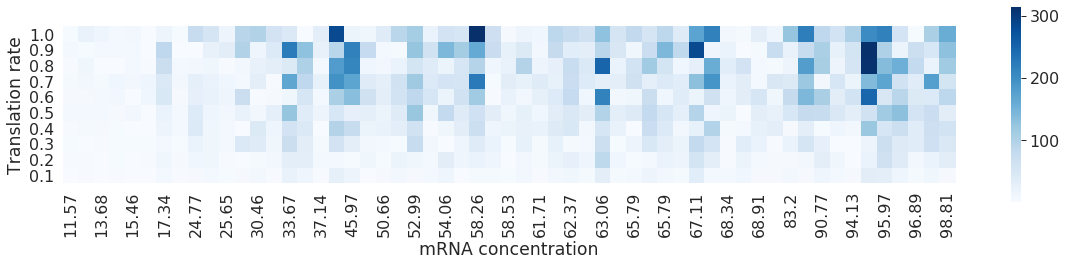

In [18]:
all_endpoints = pd.DataFrame(np.array(different_experiments)[:, :, -1],).transpose() 
all_endpoints.columns = np.round(mRNAs, 2)
all_endpoints.index = np.round(k_translations, 2)


plt.figure(figsize=(20, 4))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)

ax = sns.heatmap(all_endpoints[np.sort(np.round(mRNAs, 2)[np.arange(0, 1000, 20)])], cmap='Blues', \
                square=True, cbar_kws={"shrink": .9})
ax.set_xlabel('mRNA concentration')
ax.set_ylabel('Translation rate')
ax.invert_yaxis();
# plt.savefig('figs/heatmap_translation_rates_vs_mRNA.pdf',  bbox_inches='tight', pad_inches=0)
plt.savefig('figs/protein_vs_translation_rates_vs_mRNA_steady_state.png', bbox_inches='tight', pad_inches=0)